In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
plot_fs = 12

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('axes', labelsize=10)
mpl.rcParams['lines.dashed_pattern'] = [2, 2]
mpl.rcParams['lines.linewidth'] = 1.0

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.learning.blr_slip import SlipBayesianLinearRegression, FullBodySlipBayesianLinearRegression
from models.learning.blr_slip_acceleration import SlipAccelerationBayesianLinearRegression, FullBodySlipAccelerationBayesianLinearRegression
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *

from util.transform_algebra import *
from util.util_func import *

3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]


In [3]:
# import slip dataset

# dataset_path = '../data/ral2023_dataset/husky/boreal_snow/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/husky/grand_salon_tile_inflated/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/husky/grand_salon_left-deflated/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/marmotte/boreal_snow/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/marmotte/ga_hard_snow_a/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/marmotte/ga_hard_snow_b/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/marmotte/grand_salon_tile_b/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/warthog_tracks/boreal_mud/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/warthog_tracks/grand-axe_crusted-snow/slip_dataset_all.pkl'

# dataset_path = '../data/ral2023_dataset/husky/boreal_snow/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/husky/grand_salon_tile_inflated/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/husky/grand_salon_left-deflated/acceleration_dataset.pkl'
dataset_path = '../data/ral2023_dataset/marmotte/boreal_snow/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/marmotte/ga_hard_snow_a/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/marmotte/ga_hard_snow_b/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/marmotte/grand_salon_tile_b/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/warthog_tracks/boreal_mud/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/warthog_tracks/grand-axe_crusted-snow/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/warthog_wheels/gravel_1/acceleration_dataset.pkl'

human_dataset = pd.read_csv('../data/ral2023_dataset/warthog_wheels/crv2020/human-commanded_speeds.csv')


full_dataset = pd.read_pickle(dataset_path)
full_dataset_length = len(full_dataset)
train_dataset = full_dataset[:int(full_dataset_length/2)]
validate_dataset = full_dataset[int(full_dataset_length/2):]
train_dataset_human = train_dataset[:int(len(train_dataset)/2)]
train_dataset_doughnut = train_dataset[int(len(train_dataset)/2):]

print(train_dataset.columns)
print(len(train_dataset_human))
print(len(train_dataset_doughnut))

Index(['init_icp_x', 'init_icp_y', 'init_icp_z', 'init_icp_roll',
       'init_icp_pitch', 'init_icp_yaw', 'calib_step', 'cmd_left_0',
       'cmd_right_0', 'cmd_left_1',
       ...
       'icp_acceleration_yaw_30', 'icp_acceleration_yaw_31',
       'icp_acceleration_yaw_32', 'icp_acceleration_yaw_33',
       'icp_acceleration_yaw_34', 'icp_acceleration_yaw_35',
       'icp_acceleration_yaw_36', 'icp_acceleration_yaw_37',
       'icp_acceleration_yaw_38', 'icp_acceleration_yaw_39'],
      dtype='object', length=1458)
154
155


In [4]:
# isolate steady-state data

# extract cmd_body_vel arrays (input arrays)

idd_body_vel_x_str_list = []
idd_body_vel_y_str_list = []
idd_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_idd_vel_x_i = 'idd_vel_x_' + str(i)
    str_idd_vel_y_i = 'idd_vel_y_' + str(i)
    str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
    idd_body_vel_x_str_list.append(str_idd_vel_x_i)
    idd_body_vel_y_str_list.append(str_idd_vel_y_i)
    idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
idd_body_vel_x_array = train_dataset_human[idd_body_vel_x_str_list].to_numpy()
idd_body_vel_y_array = train_dataset_human[idd_body_vel_y_str_list].to_numpy()
idd_body_vel_yaw_array = train_dataset_human[idd_body_vel_yaw_str_list].to_numpy()

x_train = np.column_stack((idd_body_vel_x_array.flatten(), idd_body_vel_yaw_array.flatten()))

wheel_radius = 0.3
baseline = 1.1652
ideal_diff_drive = Ideal_diff_drive(wheel_radius, baseline, dt=0.05)
encoder_left_str_list = []
encoder_right_str_list = []
for i in range(0, 40):
    str_encoder_left_i = 'left_wheel_vel_' + str(i)
    str_encoder_right_i = 'right_wheel_vel_' + str(i)
    encoder_left_str_list.append(str_encoder_left_i)
    encoder_right_str_list.append(str_encoder_right_i)
encoder_left_vels = train_dataset_human[encoder_left_str_list].to_numpy()
encoder_right_vels = train_dataset_human[encoder_right_str_list].to_numpy()
encoder_body_vel_x = np.zeros((encoder_left_vels.shape[0], 40))
encoder_body_vel_yaw = np.zeros((encoder_left_vels.shape[0], 40))
for i in range(0, encoder_left_vels.shape[0]):
    for j in range(0, 40):
        body_vel = ideal_diff_drive.compute_body_vel(np.array([encoder_left_vels[i,j], encoder_right_vels[i, j]]))
        encoder_body_vel_x[i,j] = body_vel[0]
        encoder_body_vel_yaw[i,j] = body_vel[1]

# extract icp vels

str_icp_vel_x_list = []
str_icp_vel_y_list = []
str_icp_vel_yaw_list = []
for i in range(0, 40):
    str_icp_vel_x_i = 'icp_vel_x_' + str(i)
    str_icp_vel_y_i = 'icp_vel_y_' + str(i)
    str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
    str_icp_vel_x_list.append(str_icp_vel_x_i)
    str_icp_vel_y_list.append(str_icp_vel_y_i)
    str_icp_vel_yaw_list.append(str_icp_vel_yaw_i)
icp_vel_x_array = train_dataset_human[str_icp_vel_x_list].to_numpy()
icp_vel_y_array = train_dataset_human[str_icp_vel_y_list].to_numpy()
icp_vel_yaw_array = train_dataset_human[str_icp_vel_yaw_list].to_numpy()

# extract body_vel_distruptions arrays (output arrays)

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)

body_vel_disturption_x_array = train_dataset_human[str_body_vel_disturption_x_list].to_numpy()
body_vel_disturption_y_array = train_dataset_human[str_body_vel_disturption_y_list].to_numpy()
body_vel_disturption_yaw_array = train_dataset_human[str_body_vel_disturption_yaw_list].to_numpy()

y_train_longitudinal_slip = body_vel_disturption_x_array.flatten()
y_train_lateral_slip = body_vel_disturption_y_array.flatten()
y_train_angular_slip = body_vel_disturption_yaw_array.flatten()

# compute mean body vel disturbance for each steady-state window
n_windows = len(train_dataset_human)

steady_state_mask = train_dataset_human['steady_state_mask'].to_numpy() == True

steady_state_idd_body_vel_x = idd_body_vel_x_array[steady_state_mask]
steady_state_idd_body_vel_y = idd_body_vel_y_array[steady_state_mask]
steady_state_idd_body_vel_yaw = idd_body_vel_yaw_array[steady_state_mask]

steady_state_encoder_body_vel_x = encoder_body_vel_x[steady_state_mask]
steady_state_encoder_body_vel_yaw = encoder_body_vel_yaw[steady_state_mask]

steady_state_icp_body_vel_x = icp_vel_x_array[steady_state_mask]
steady_state_icp_body_vel_y = icp_vel_y_array[steady_state_mask]
steady_state_icp_body_vel_yaw = icp_vel_yaw_array[steady_state_mask]

steady_state_body_vel_disturption_x = body_vel_disturption_x_array[steady_state_mask]
steady_state_body_vel_disturption_y = body_vel_disturption_y_array[steady_state_mask]
steady_state_body_vel_disturption_yaw = body_vel_disturption_yaw_array[steady_state_mask]


In [5]:
# isolate steady-state data

# extract cmd_body_vel arrays (input arrays)

idd_body_vel_x_str_list = []
idd_body_vel_y_str_list = []
idd_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_idd_vel_x_i = 'idd_vel_x_' + str(i)
    str_idd_vel_y_i = 'idd_vel_y_' + str(i)
    str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
    idd_body_vel_x_str_list.append(str_idd_vel_x_i)
    idd_body_vel_y_str_list.append(str_idd_vel_y_i)
    idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
idd_body_vel_x_array = train_dataset_doughnut[idd_body_vel_x_str_list].to_numpy()
idd_body_vel_y_array = train_dataset_doughnut[idd_body_vel_y_str_list].to_numpy()
idd_body_vel_yaw_array = train_dataset_doughnut[idd_body_vel_yaw_str_list].to_numpy()

x_train = np.column_stack((idd_body_vel_x_array.flatten(), idd_body_vel_yaw_array.flatten()))

wheel_radius = 0.3
baseline = 1.1652
ideal_diff_drive = Ideal_diff_drive(wheel_radius, baseline, dt=0.05)
encoder_left_str_list = []
encoder_right_str_list = []
for i in range(0, 40):
    str_encoder_left_i = 'left_wheel_vel_' + str(i)
    str_encoder_right_i = 'right_wheel_vel_' + str(i)
    encoder_left_str_list.append(str_encoder_left_i)
    encoder_right_str_list.append(str_encoder_right_i)
encoder_left_vels = train_dataset_doughnut[encoder_left_str_list].to_numpy()
encoder_right_vels = train_dataset_doughnut[encoder_right_str_list].to_numpy()
encoder_body_vel_x = np.zeros((encoder_left_vels.shape[0], 40))
encoder_body_vel_yaw = np.zeros((encoder_left_vels.shape[0], 40))
for i in range(0, encoder_left_vels.shape[0]):
    for j in range(0, 40):
        body_vel = ideal_diff_drive.compute_body_vel(np.array([encoder_left_vels[i,j], encoder_right_vels[i, j]]))
        encoder_body_vel_x[i,j] = body_vel[0]
        encoder_body_vel_yaw[i,j] = body_vel[1]

# extract icp vels

str_icp_vel_x_list = []
str_icp_vel_y_list = []
str_icp_vel_yaw_list = []
for i in range(0, 40):
    str_icp_vel_x_i = 'icp_vel_x_' + str(i)
    str_icp_vel_y_i = 'icp_vel_y_' + str(i)
    str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
    str_icp_vel_x_list.append(str_icp_vel_x_i)
    str_icp_vel_y_list.append(str_icp_vel_y_i)
    str_icp_vel_yaw_list.append(str_icp_vel_yaw_i)
icp_vel_x_array = train_dataset_doughnut[str_icp_vel_x_list].to_numpy()
icp_vel_y_array = train_dataset_doughnut[str_icp_vel_y_list].to_numpy()
icp_vel_yaw_array = train_dataset_doughnut[str_icp_vel_yaw_list].to_numpy()

# extract body_vel_distruptions arrays (output arrays)

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)

body_vel_disturption_x_array = train_dataset_doughnut[str_body_vel_disturption_x_list].to_numpy()
body_vel_disturption_y_array = train_dataset_doughnut[str_body_vel_disturption_y_list].to_numpy()
body_vel_disturption_yaw_array = train_dataset_doughnut[str_body_vel_disturption_yaw_list].to_numpy()

y_train_longitudinal_slip = body_vel_disturption_x_array.flatten()
y_train_lateral_slip = body_vel_disturption_y_array.flatten()
y_train_angular_slip = body_vel_disturption_yaw_array.flatten()

# compute mean body vel disturbance for each steady-state window
n_windows = len(train_dataset_doughnut)

steady_state_mask = train_dataset_doughnut['steady_state_mask'].to_numpy() == True

steady_state_idd_body_vel_x_doughnut = idd_body_vel_x_array[steady_state_mask]
steady_state_idd_body_vel_y_doughnut = idd_body_vel_y_array[steady_state_mask]
steady_state_idd_body_vel_yaw_doughnut = idd_body_vel_yaw_array[steady_state_mask]

steady_state_encoder_body_vel_x_doughnut = encoder_body_vel_x[steady_state_mask]
steady_state_encoder_body_vel_yaw_doughnut = encoder_body_vel_yaw[steady_state_mask]

steady_state_icp_body_vel_x_doughnut = icp_vel_x_array[steady_state_mask]
steady_state_icp_body_vel_y_doughnut = icp_vel_y_array[steady_state_mask]
steady_state_icp_body_vel_yaw_doughnut = icp_vel_yaw_array[steady_state_mask]

steady_state_body_vel_disturption_x_doughnut = body_vel_disturption_x_array[steady_state_mask]
steady_state_body_vel_disturption_y_doughnut = body_vel_disturption_y_array[steady_state_mask]
steady_state_body_vel_disturption_yaw_doughnut = body_vel_disturption_yaw_array[steady_state_mask]


In [6]:
# import powertrain vels

cmd_left_str_list = []
cmd_right_str_list = []
for i in range(0, 40):
    str_cmd_left_i = 'cmd_left_' + str(i)
    str_cmd_right_i = 'cmd_right_' + str(i)
    cmd_left_str_list.append(str_cmd_left_i)
    cmd_right_str_list.append(str_cmd_right_i)
# cmd_left_vels_array = validate_dataset[cmd_left_str_list].to_numpy()
# cmd_right_vels_array = validate_dataset[cmd_right_str_list].to_numpy()

encoder_left_str_list = []
encoder_right_str_list = []
for i in range(0, 40):
    str_encoder_left_i = 'left_wheel_vel_' + str(i)
    str_encoder_right_i = 'right_wheel_vel_' + str(i)
    encoder_left_str_list.append(str_encoder_left_i)
    encoder_right_str_list.append(str_encoder_right_i)
# encoder_left_vels_array = validate_dataset[encoder_left_str_list].to_numpy()
# encoder_right_vels_array = validate_dataset[encoder_right_str_list].to_numpy()

transitory_left_str_list = []
transitory_right_str_list = []
for i in range(0, 40):
    str_transitory_left_i = 'transitory_vel_left_' + str(i)
    str_transitory_right_i = 'transitory_vel_right_' + str(i)
    transitory_left_str_list.append(str_transitory_left_i)
    transitory_right_str_list.append(str_transitory_right_i)
# transitory_left_vels_array = validate_dataset[transitory_left_str_list].to_numpy()
# transitory_right_vels_array = validate_dataset[transitory_right_str_list].to_numpy()

# extract cmd_body_vel arrays (input arrays)

idd_body_vel_x_str_list = []
idd_body_vel_y_str_list = []
idd_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_idd_vel_x_i = 'idd_vel_x_' + str(i)
    str_idd_vel_y_i = 'idd_vel_y_' + str(i)
    str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
    idd_body_vel_x_str_list.append(str_idd_vel_x_i)
    idd_body_vel_y_str_list.append(str_idd_vel_y_i)
    idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
# idd_body_vel_x_array = validate_dataset[idd_body_vel_x_str_list].to_numpy()
# idd_body_vel_y_array = validate_dataset[idd_body_vel_y_str_list].to_numpy()
# idd_body_vel_yaw_array = validate_dataset[idd_body_vel_yaw_str_list].to_numpy()

icp_x_str_list = []
icp_y_str_list = []
icp_z_str_list = []
icp_roll_str_list = []
icp_pitch_str_list = []
icp_yaw_str_list = []
for i in range(0, 40):
    str_icp_x_i = 'icp_interpolated_x_' + str(i)
    str_icp_y_i = 'icp_interpolated_y_' + str(i)
    str_icp_yaw_i = 'icp_interpolated_yaw_' + str(i)
    icp_x_str_list.append(str_icp_x_i)
    icp_y_str_list.append(str_icp_y_i)
    icp_yaw_str_list.append(str_icp_yaw_i)
# icp_x_array = validate_dataset[icp_x_str_list].to_numpy()
# icp_y_array = validate_dataset[icp_y_str_list].to_numpy()
# icp_yaw_array = validate_dataset[icp_yaw_str_list].to_numpy()

# extract icp vels

str_icp_vel_x_list = []
str_icp_vel_y_list = []
str_icp_vel_yaw_list = []
for i in range(0, 40):
    str_icp_vel_x_i = 'icp_vel_x_' + str(i)
    str_icp_vel_y_i = 'icp_vel_y_' + str(i)
    str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
    str_icp_vel_x_list.append(str_icp_vel_x_i)
    str_icp_vel_y_list.append(str_icp_vel_y_i)
    str_icp_vel_yaw_list.append(str_icp_vel_yaw_i)
icp_vel_x_array = validate_dataset[str_icp_vel_x_list].to_numpy()
icp_vel_y_array = validate_dataset[str_icp_vel_y_list].to_numpy()
icp_vel_yaw_array = validate_dataset[str_icp_vel_yaw_list].to_numpy()

# extract body_vel_distruptions arrays (output arrays)

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)

# body_vel_disturption_x_array = validate_dataset[str_body_vel_disturption_x_list].to_numpy()
# body_vel_disturption_y_array = validate_dataset[str_body_vel_disturption_y_list].to_numpy()
# body_vel_disturption_yaw_array = validate_dataset[str_body_vel_disturption_yaw_list].to_numpy()

In [16]:
# define cmd_vel mask

q1_calib_mask = np.full(steady_state_idd_body_vel_x.shape[0], False)
q2_calib_mask = np.full(steady_state_idd_body_vel_x.shape[0], False)
q3_calib_mask = np.full(steady_state_idd_body_vel_x.shape[0], False)
q4_calib_mask = np.full(steady_state_idd_body_vel_x.shape[0], False)
random_calib_mask = np.full(steady_state_idd_body_vel_x.shape[0], False)

q1_calib_counter = 0
q2_calib_counter = 0
q3_calib_counter = 0
q4_calib_counter = 0

for i in range(0, steady_state_idd_body_vel_x.shape[0]):
    if steady_state_idd_body_vel_x[i, 0] >= 0 and np.abs(steady_state_idd_body_vel_yaw[i, 0]) <= np.abs(steady_state_idd_body_vel_x[i, 0]) * 4.0:
    # if np.abs(steady_state_idd_body_vel_yaw[i, 0]) <= np.abs(steady_state_idd_body_vel_x[i, 0]) * 4.0:
        q1_calib_mask[i] = True
        q1_calib_counter += 1

    # if steady_state_idd_body_vel_yaw[i, 0] >= 0 and np.abs(steady_state_idd_body_vel_x[i, 0]) <= np.abs(steady_state_idd_body_vel_yaw[i, 0]) * 0.5:
    if np.abs(steady_state_idd_body_vel_x[i, 0]) <= np.abs(steady_state_idd_body_vel_yaw[i, 0]) * 0.5:
        q2_calib_mask[i] = True
        q2_calib_counter += 1

    if steady_state_idd_body_vel_x[i, 0] <= 0 and np.abs(steady_state_idd_body_vel_yaw[i, 0]) <= np.abs(steady_state_idd_body_vel_x[i, 0]) * 4.0:
        q3_calib_mask[i] = True
        q3_calib_counter += 1

    if steady_state_idd_body_vel_yaw[i, 0] <= 0 and np.abs(steady_state_idd_body_vel_x[i, 0]) <= np.abs(steady_state_idd_body_vel_yaw[i, 0]) * 0.5:
        q4_calib_mask[i] = True
        q4_calib_counter += 1

random_calib_mask[:q1_calib_counter] = True
# random_calib_mask[:] = True

print(q1_calib_mask.shape)
print(steady_state_idd_body_vel_yaw.shape)
print(steady_state_idd_body_vel_x.shape)

(102,)
(102, 40)
(102, 40)


/var/folders/81/fnt9x6_x5l343vfsqmvf5fd40000gn/T/ipykernel_2306/1132994353.py:91: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


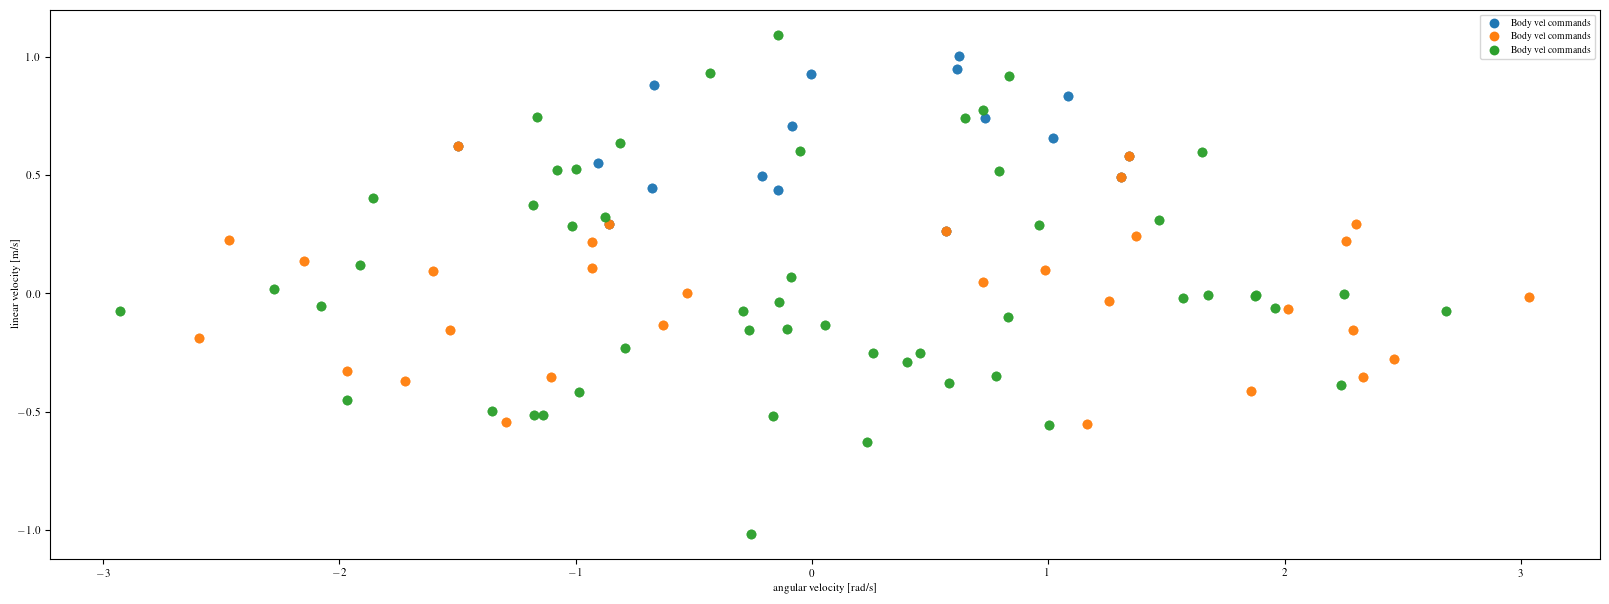

In [17]:
plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

# df_filtered = autorally_df[(autorally_df.linear_v < 25)] #Super weird ultra large values on linar velocity
# print("filtered {} data points".format(len(autorally_df)-len(df_filtered)))

# max_lv = max(np.abs(df_filtered['linear_v']))
# max_av = max(np.abs(df_filtered['angular_v']))


# meas = ax.scatter(df_filtered['angular_v']/(max_av/2.5), df_filtered['linear_v']/(max_lv/2.5),
#                   c = 'tab:green',
#                   cmap = 'hot',
#                   alpha = 0.05,
#                   lw=0,
#                   s=5,
#                   label='Autorally encoders-based body velocities',
#                  rasterized=True)

line_width = 5
alpha = 0.2


# q1_char_input_space = ax.plot(char_angular_vel_linspace_negative, char_q1_vel_linspace, color='C2', lw=line_width, label='Characterized')
# q2_char_input_space = ax.plot(char_angular_vel_linspace_positive, char_q2_vel_linspace, color='C2', lw=line_width)
# q3_char_input_space = ax.plot(char_angular_vel_linspace_positive, char_q3_vel_linspace, color='C2', lw=line_width)
# q4_char_input_space = ax.plot(char_angular_vel_linspace_negative, char_q4_vel_linspace, color='C2', lw=line_width)

alpha_plot = 0.8

# icp = ax.scatter(steady_state_icp_body_vel_yaw[:, 0], steady_state_icp_body_vel_x[:, 0],
#                   c = 'C0',
#                   cmap = 'hot',
#                   alpha = alpha_plot,
#                   lw=0,
#                   s=50,
#                   label='ICP (lon) and IMU (ang)',
#                  rasterized=True)



# human = ax.scatter(human_dataset['cmd_vel_omega'], human_dataset['cmd_vel_x'],
#                   c = 'C0',
#                   cmap = 'viridis',
#                   alpha = 0.2,
#                   lw=0,
#                   s=50,
#                   label='Body vel commands',
#                  rasterized=True)

# cmd = ax.scatter(steady_state_idd_body_vel_yaw[:, 0], steady_state_idd_body_vel_x[:, 0],
#                   c = q4_calib_mask,
#                   cmap = 'viridis',
#                   alpha = alpha_plot,
#                   lw=0,
#                   s=50,
#                   label='Body vel commands',
#                  rasterized=True)

linear = ax.scatter(steady_state_idd_body_vel_yaw[q1_calib_mask, 0], steady_state_idd_body_vel_x[q1_calib_mask, 0],
                  alpha = alpha_plot,
                    c='C0',
                  lw=0,
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

angular = ax.scatter(steady_state_idd_body_vel_yaw[q2_calib_mask, 0], steady_state_idd_body_vel_x[q2_calib_mask, 0],
                  alpha = alpha_plot,
                     c='C1',
                  lw=0,
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

doughnut = ax.scatter(steady_state_idd_body_vel_yaw_doughnut[:, 0], steady_state_idd_body_vel_x_doughnut[:, 0],
                  alpha = alpha_plot,
                     c='C2',
                  lw=0,
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

ax.set_aspect('equal', 'box')

ax.set_ylabel('linear velocity [m/s]', labelpad=-2)
ax.set_xlabel('angular velocity [rad/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles:
    lh.set_alpha(1)

# ax.set_xlim(-5, 5)
# ax.set_ylim(-2, 2.0)

# ax.set_xticks([-1,0,1])
# ax.set_yticks([-1,0,1])
# ax.set_xticklabels([r'$-\dot{\theta}_{max}$', '0', r'$\dot{\theta}_{max}$'])
# ax.set_yticklabels([r'$-v_{max}$', '0', r'$v_{max}$'])

# fig.subplots_adjust(left=.15, bottom=.17, right=.98, top=.98)
# fig.set_size_inches(width, height)

plt.savefig('figs/sota_calib_cs_doughnut_mask.jpg')

In [18]:
# train with or without mask

# import BLR model


slip_input_dimensions = 2
a_param_init = 0
b_param_init = 0
param_variance_init = 999999999999999999999
variance_init = 1000000000

robot = 'husky'
# robot = 'marmotte'
# robot = 'warthog-track'
if robot=='husky':
    wheel_radius = 0.33 / 2
    baseline = 0.55
    dt=0.05
if robot=='marmotte':
    wheel_radius = 0.116
    baseline = 0.5927
    dt=0.05
if robot == 'warthog-track':
    wheel_radius = 0.3
    baseline = 1.1652
    dt = 0.05
kappa_param = 1

# full_body_slip_blr = FullBodySlipBayesianLinearRegression(1, 1, 3, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
full_body_slip_blr_full_input_space = FullBodySlipBayesianLinearRegression(1,1,3, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
full_body_slip_blr_human = FullBodySlipBayesianLinearRegression(1,1,3, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)

In [19]:
# extract training data

x_train_human = np.column_stack((steady_state_idd_body_vel_x[q1_calib_mask].flatten(), steady_state_idd_body_vel_y[q1_calib_mask].flatten(), steady_state_idd_body_vel_yaw[q1_calib_mask].flatten()))
y_train_human = np.column_stack((steady_state_body_vel_disturption_x[q1_calib_mask].flatten(), steady_state_body_vel_disturption_y[q1_calib_mask].flatten(), steady_state_body_vel_disturption_yaw[q1_calib_mask].flatten()))

x_train_full = np.column_stack((steady_state_idd_body_vel_x[random_calib_mask].flatten(), steady_state_idd_body_vel_y[random_calib_mask].flatten(), steady_state_idd_body_vel_yaw[random_calib_mask].flatten()))
y_train_full = np.column_stack((steady_state_body_vel_disturption_x[random_calib_mask].flatten(), steady_state_body_vel_disturption_y[random_calib_mask].flatten(), steady_state_body_vel_disturption_yaw[random_calib_mask].flatten()))

print(x_train_full.shape)
print(x_train_human.shape)

(1360, 3)
(1360, 3)


In [20]:
full_body_slip_blr_full_input_space.train_params(x_train_full, y_train_full)
full_body_slip_blr_human.train_params(x_train_human, y_train_human)

print('weights_x_full : ', full_body_slip_blr_full_input_space.body_x_slip_blr.weights)
print('weights_y_full : ', full_body_slip_blr_full_input_space.body_y_slip_blr.weights)
print('weights_yaw_full : ', full_body_slip_blr_full_input_space.body_yaw_slip_blr.weights)

print('weights_x_human : ', full_body_slip_blr_human.body_x_slip_blr.weights)
print('weights_y_human : ', full_body_slip_blr_human.body_y_slip_blr.weights)
print('weights_yaw_human : ', full_body_slip_blr_human.body_yaw_slip_blr.weights)

weights_x_full :  [[0.16060468]]
weights_y_full :  [[0.08646635]]
weights_yaw_full :  [[-0.05045367]
 [-0.03797245]
 [ 0.09464675]]
weights_x_human :  [[0.13126859]]
weights_y_human :  [[0.18223079]]
weights_yaw_human :  [[ 0.57800812]
 [-0.01654231]
 [-0.33848283]]


In [21]:
# Evaluation for 2 second horizons

window_size = 40

def compute_single_step_error(meas_state, pred_state):
    pred_error = meas_state - pred_state
    pred_error[2] = wrap2pi(pred_error[2]) # wrap yaw angle error to pi
    translation_error_squared_scalar = pred_error.T @ np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]]) @ pred_error
    rotation_error_squared_scalar = pred_error.T @ np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]) @ pred_error
    return np.sqrt(translation_error_squared_scalar), np.sqrt(rotation_error_squared_scalar)

def compute_prediction_metrics(validate_dataset, robot):
    n_test_windows = len(validate_dataset)

    cmd_left_vels_array = validate_dataset[cmd_left_str_list].to_numpy()
    cmd_right_vels_array = validate_dataset[cmd_right_str_list].to_numpy()
    transitory_left_vels_array = validate_dataset[transitory_left_str_list].to_numpy()
    transitory_right_vels_array = validate_dataset[transitory_right_str_list].to_numpy()
    idd_body_vel_x_array = validate_dataset[idd_body_vel_x_str_list].to_numpy()
    idd_body_vel_y_array = validate_dataset[idd_body_vel_y_str_list].to_numpy()
    idd_body_vel_yaw_array = validate_dataset[idd_body_vel_yaw_str_list].to_numpy()
    icp_x_array = validate_dataset[icp_x_str_list].to_numpy()
    icp_y_array = validate_dataset[icp_y_str_list].to_numpy()
    icp_yaw_array = validate_dataset[icp_yaw_str_list].to_numpy()
    icp_vel_x_array = validate_dataset[str_icp_vel_x_list].to_numpy()
    icp_vel_y_array = validate_dataset[str_icp_vel_y_list].to_numpy()
    icp_vel_yaw_array = validate_dataset[str_icp_vel_yaw_list].to_numpy()

    # TODO : Try only in steady-state or transitory-state windows to check if models perform better in some cases

    if robot=='H':
        wheel_radius = 0.33 / 2
        baseline = 0.55
        dt = 0.05
    if robot=='M':
        wheel_radius = 0.116
        baseline = 0.5927
        dt=0.05
    if robot == 'W':
        wheel_radius = 0.3
        baseline = 1.1652
        dt = 0.05

    ideal_diff_drive = Ideal_diff_drive(wheel_radius, baseline, dt)

    cmd_input_horizon = np.zeros((2, window_size))
    transitory_input_horizon = np.zeros((2, window_size))
    transitory_body_vel_horizon = np.zeros((3, window_size))

    cmd_idd_horizon_prediction = np.zeros((3, window_size))
    transitory_idd_horizon_prediction = np.zeros((3, window_size))
    blr_slip_horizon_prediction = np.zeros((3, window_size))
    icp_horizon_meas = np.zeros((3, window_size))
    icp_vel_meas = np.zeros((3, window_size))

    blr_slip_prediction_errors_human_translation = np.zeros(n_test_windows)
    blr_slip_prediction_errors_human_rotation = np.zeros(n_test_windows)
    blr_slip_prediction_errors_full_input_space_translation = np.zeros(n_test_windows)
    blr_slip_prediction_errors_full_input_space_rotation = np.zeros(n_test_windows)
    idd_body_vels_array = np.zeros((window_size, 3))
    blr_init_state_covariance = np.eye(3) * 0.1

    for j in range(0, n_test_windows):
        # if not steady_state_mask_array[j]:
        #     continue
        cmd_input_horizon[0, :] = cmd_left_vels_array[j, :]
        cmd_input_horizon[1, :] = cmd_right_vels_array[j, :]

        transitory_input_horizon[0, :] = transitory_left_vels_array[j, :]
        transitory_input_horizon[1, :] = transitory_right_vels_array[j, :]

        transitory_body_vel_horizon[0, :] = idd_body_vel_x_array[j, :]
        transitory_body_vel_horizon[1, :] = idd_body_vel_y_array[j, :]
        transitory_body_vel_horizon[2, :] = idd_body_vel_yaw_array[j, :]

        blr_horizon_prediction_error_human_translation = 0
        blr_horizon_prediction_error_human_rotation = 0
        blr_horizon_prediction_error_full_input_space_translation = 0
        blr_horizon_prediction_error_full_input_space_rotation = 0

        idd_body_vels_array[:, 0] = idd_body_vel_x_array[j, :]
        idd_body_vels_array[:, 1] = idd_body_vel_y_array[j, :]
        idd_body_vels_array[:, 2] = idd_body_vel_yaw_array[j, :]

        icp_vel_meas[0, :] = icp_vel_x_array[j, :]
        icp_vel_meas[1, :] = icp_vel_y_array[j, :]
        icp_vel_meas[2, :] = icp_vel_yaw_array[j, :]

        prediction_means_blr_human, prediction_covariances_blr_human = full_body_slip_blr_human.predict_horizon_from_body_idd_vels(idd_body_vels_array,
                                                                                                        blr_slip_horizon_prediction[:, 0], blr_init_state_covariance)
        prediction_means_blr_full_input_space, prediction_covariances_blr_full_input_space = full_body_slip_blr_full_input_space.predict_horizon_from_body_idd_vels(idd_body_vels_array,
                                                                                                        blr_slip_horizon_prediction[:, 0], blr_init_state_covariance)

        icp_horizon_meas[0, :] = icp_x_array[j, :]
        icp_horizon_meas[1, :] = icp_y_array[j, :]
        icp_horizon_meas[2, :] = icp_yaw_array[j, :]

        for i in range(0, window_size):
            icp_2d_state = np.array([icp_x_array[j, i], icp_y_array[j, i], icp_yaw_array[j, i]])
            blr_horizon_prediction_error_human_translation_step, blr_horizon_prediction_error_human_rotation_step = compute_single_step_error(icp_2d_state, prediction_means_blr_human[:, i])
            blr_horizon_prediction_error_human_translation += blr_horizon_prediction_error_human_translation_step
            blr_horizon_prediction_error_human_rotation += blr_horizon_prediction_error_human_rotation_step

            blr_horizon_prediction_error_full_input_space_translation_step, blr_horizon_prediction_error_full_input_space_rotation_step = compute_single_step_error(icp_2d_state, prediction_means_blr_full_input_space[:, i])
            blr_horizon_prediction_error_full_input_space_translation += blr_horizon_prediction_error_full_input_space_translation_step
            blr_horizon_prediction_error_full_input_space_rotation += blr_horizon_prediction_error_full_input_space_rotation_step

        # blr_msre = np.diag(blr_prediction_errors @ blr_prediction_errors.T)
        # blr_slip_prediction_errors[j] = np.sqrt(np.sqrt((blr_msre.T @ blr_msre) / window_size))

        # print('blr : ', prediction_means_blr[2, -1])
        # print('icp : ', icp_horizon_meas[2, -1])

        # print(prediction_means_blr_human)
        blr_slip_prediction_errors_human_translation[j] = blr_horizon_prediction_error_human_translation / window_size
        blr_slip_prediction_errors_human_rotation[j] = blr_horizon_prediction_error_human_rotation / window_size
        blr_slip_prediction_errors_full_input_space_translation[j] = blr_horizon_prediction_error_full_input_space_translation / window_size
        blr_slip_prediction_errors_full_input_space_rotation[j] = blr_horizon_prediction_error_full_input_space_rotation / window_size

    # cmd_idd_prediction_errors = cmd_idd_prediction_errors[steady_state_mask_array]
    # transitory_idd_prediction_errors = transitory_idd_prediction_errors[steady_state_mask_array]
    # blr_slip_prediction_errors = blr_slip_prediction_errors[steady_state_mask_array]
    # gp_slip_prediction_errors = gp_slip_prediction_errors[steady_state_mask_array]
    # blr_acceleration_prediction_errors = blr_acceleration_prediction_errors[steady_state_mask_array]
    # blr_slip_acceleration_prediction_errors = blr_slip_acceleration_prediction_errors[steady_state_mask_array]

    return blr_slip_prediction_errors_human_translation, blr_slip_prediction_errors_human_rotation, blr_slip_prediction_errors_full_input_space_translation, blr_slip_prediction_errors_full_input_space_rotation



In [22]:
x_train_full = np.column_stack((steady_state_idd_body_vel_x_doughnut.flatten(), steady_state_idd_body_vel_y_doughnut.flatten(), steady_state_idd_body_vel_yaw_doughnut.flatten()))
y_train_full = np.column_stack((steady_state_body_vel_disturption_x_doughnut.flatten(), steady_state_body_vel_disturption_y_doughnut.flatten(), steady_state_body_vel_disturption_yaw_doughnut.flatten()))

full_body_slip_blr_full_input_space.train_params(x_train_full, y_train_full)

x_train_q1 = np.column_stack((steady_state_idd_body_vel_x[q1_calib_mask].flatten(), steady_state_idd_body_vel_y[q1_calib_mask].flatten(), steady_state_idd_body_vel_yaw[q1_calib_mask].flatten()))
y_train_q1 = np.column_stack((steady_state_body_vel_disturption_x[q1_calib_mask].flatten(), steady_state_body_vel_disturption_y[q1_calib_mask].flatten(), steady_state_body_vel_disturption_yaw[q1_calib_mask].flatten()))
encoder_q1 = np.column_stack((steady_state_encoder_body_vel_x[q1_calib_mask].flatten(), steady_state_idd_body_vel_y[q1_calib_mask].flatten(), steady_state_encoder_body_vel_yaw[q1_calib_mask].flatten()))

full_body_slip_blr_human.train_params(x_train_q1, y_train_q1)

blr_slip_prediction_errors_q1_translation, blr_slip_prediction_errors_q1_rotation, blr_slip_prediction_errors_full_input_space_translation, blr_slip_prediction_errors_full_input_space_rotation = compute_prediction_metrics(validate_dataset, 'M')

x_train_q2 = np.column_stack((steady_state_idd_body_vel_x[q2_calib_mask].flatten(), steady_state_idd_body_vel_y[q2_calib_mask].flatten(), steady_state_idd_body_vel_yaw[q2_calib_mask].flatten()))
y_train_q2 = np.column_stack((steady_state_body_vel_disturption_x[q2_calib_mask].flatten(), steady_state_body_vel_disturption_y[q2_calib_mask].flatten(), steady_state_body_vel_disturption_yaw[q2_calib_mask].flatten()))
encoder_q2 = np.column_stack((steady_state_encoder_body_vel_x[q2_calib_mask].flatten(), steady_state_idd_body_vel_y[q2_calib_mask].flatten(), steady_state_encoder_body_vel_yaw[q2_calib_mask].flatten()))

full_body_slip_blr_human.train_params(x_train_q2, y_train_q2)

blr_slip_prediction_errors_q2_translation, blr_slip_prediction_errors_q2_rotation, blr_slip_prediction_errors_full_input_space_translation, blr_slip_prediction_errors_full_input_space_rotation = compute_prediction_metrics(validate_dataset, 'M')

x_train_q3 = np.column_stack((steady_state_idd_body_vel_x[q3_calib_mask].flatten(), steady_state_idd_body_vel_y[q3_calib_mask].flatten(), steady_state_idd_body_vel_yaw[q3_calib_mask].flatten()))
y_train_q3 = np.column_stack((steady_state_body_vel_disturption_x[q3_calib_mask].flatten(), steady_state_body_vel_disturption_y[q3_calib_mask].flatten(), steady_state_body_vel_disturption_yaw[q3_calib_mask].flatten()))
encoder_q3 = np.column_stack((steady_state_encoder_body_vel_x[q3_calib_mask].flatten(), steady_state_idd_body_vel_y[q3_calib_mask].flatten(), steady_state_encoder_body_vel_yaw[q3_calib_mask].flatten()))

full_body_slip_blr_human.train_params(x_train_q3, y_train_q3)

blr_slip_prediction_errors_q3_translation, blr_slip_prediction_errors_q3_rotation, blr_slip_prediction_errors_full_input_space_translation, blr_slip_prediction_errors_full_input_space_rotation = compute_prediction_metrics(validate_dataset, 'M')

x_train_q4 = np.column_stack((steady_state_idd_body_vel_x[q4_calib_mask].flatten(), steady_state_idd_body_vel_y[q4_calib_mask].flatten(), steady_state_idd_body_vel_yaw[q4_calib_mask].flatten()))
y_train_q4 = np.column_stack((steady_state_body_vel_disturption_x[q4_calib_mask].flatten(), steady_state_body_vel_disturption_y[q4_calib_mask].flatten(), steady_state_body_vel_disturption_yaw[q4_calib_mask].flatten()))
encoder_q4 = np.column_stack((steady_state_encoder_body_vel_x[q4_calib_mask].flatten(), steady_state_idd_body_vel_y[q4_calib_mask].flatten(), steady_state_encoder_body_vel_yaw[q4_calib_mask].flatten()))

full_body_slip_blr_human.train_params(x_train_q4, y_train_q4)

blr_slip_prediction_errors_q4_translation, blr_slip_prediction_errors_q4_rotation, blr_slip_prediction_errors_full_input_space_translation, blr_slip_prediction_errors_full_input_space_rotation = compute_prediction_metrics(validate_dataset, 'M')

/var/folders/81/fnt9x6_x5l343vfsqmvf5fd40000gn/T/ipykernel_2306/3425290641.py:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  q1 = axs0.scatter(steady_state_encoder_body_vel_yaw[q1_calib_mask, :], steady_state_encoder_body_vel_x[q1_calib_mask, :],
/var/folders/81/fnt9x6_x5l343vfsqmvf5fd40000gn/T/ipykernel_2306/3425290641.py:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  q2 = axs0.scatter(steady_state_encoder_body_vel_yaw[q2_calib_mask, :], steady_state_encoder_body_vel_x[q2_calib_mask, :],
/var/folders/81/fnt9x6_x5l343vfsqmvf5fd40000gn/T/ipykernel_2306/3425290641.py:74: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  q3 = axs0.scatter(steady_state_encoder_body_vel_yaw[q3_calib_mask, :], steady_state_encoder_body_vel_x[q3_calib_mask, :],
/var/folders/81/fnt9x6_x5l343vfsqmvf5fd40000gn/T/ipykernel_2306/3425290641.py:83: UserWarning: No data for color

Translation prediciton improvement :  -0.43173825899681273  %
Rotation prediciton improvement :  50.82825293859259  %


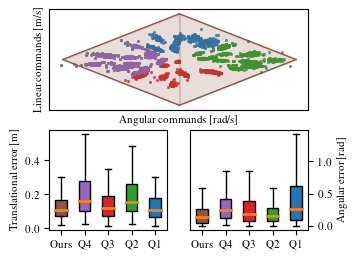

In [23]:
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Ellipse, Rectangle, FancyBboxPatch, BoxStyle
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
mpl.rcParams['lines.dashed_pattern'] = [2, 2]
mpl.rcParams['lines.linewidth'] = 1.0

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

width  = 3.402
height = width / 1.4

# fig, axs = plt.subplots(dpi=300, gridspec_kw={'hspace': 0.35, 'wspace': 0.23}, layout="constrained")

fig = plt.figure()
gs = GridSpec(2, 2)
axs0 = fig.add_subplot(gs[0, :])
axs1 = fig.add_subplot(gs[1, 0])
axs2 = fig.add_subplot(gs[1, 1])

# axs0 = plt.subplot2grid((1,1), (0,0))
# divider = make_axes_locatable(axs0)
# axs1 = divider.append_axes("bottom", size="100%", pad=0.5)
# axs2 = divider.append_axes("bottom", size="100%", pad=0.0)

fig.set_size_inches(width, height)
fig.subplots_adjust(left=.12, bottom=0.08, right=.88, top=.99)


medians_color = 'C1'
linear_color = 'C0'
angular_color = 'C2'
q3_color = 'C3'
q4_color = 'C4'
doughnut_color = 'C5'

boxplot_width = 0.5

# cmd = axs0.scatter(steady_state_idd_body_vel_yaw[:, 0], steady_state_idd_body_vel_x[:, 0],
#                   c = doughnut_color,
#                   cmap = 'cividis',
#                   alpha = alpha_plot,
#                   lw=0,
#                   s=50,
#                   label='Body vel commands',
#                  rasterized=True)

q1 = axs0.scatter(steady_state_encoder_body_vel_yaw[q1_calib_mask, :], steady_state_encoder_body_vel_x[q1_calib_mask, :],
                  c = linear_color,
                  cmap = 'cividis',
                  alpha = alpha_plot,
                  lw=0,
                  s=5,
                  label='Body vel commands',
                  rasterized=True)

q2 = axs0.scatter(steady_state_encoder_body_vel_yaw[q2_calib_mask, :], steady_state_encoder_body_vel_x[q2_calib_mask, :],
                  c = angular_color,
                  cmap = 'cividis',
                  alpha = alpha_plot,
                  lw=0,
                  s=5,
                  label='Body vel commands',
                  rasterized=True)

q3 = axs0.scatter(steady_state_encoder_body_vel_yaw[q3_calib_mask, :], steady_state_encoder_body_vel_x[q3_calib_mask, :],
                  c = q3_color,
                  cmap = 'cividis',
                  alpha = alpha_plot,
                  lw=0,
                  s=5,
                  label='Body vel commands',
                 rasterized=True)

q4 = axs0.scatter(steady_state_encoder_body_vel_yaw[q4_calib_mask, :], steady_state_encoder_body_vel_x[q4_calib_mask, :],
                  c = q4_color,
                  cmap = 'cividis',
                  alpha = alpha_plot,
                  lw=0,
                  s=5,
                  label='Body vel commands',
                 rasterized=True)

minimum_linear_vel_positive = 0
minimum_linear_vel_negative = 0
minimum_angular_vel_positive = 0
minimum_angular_vel_negative = 0
maximum_linear_vel_positive = 5
maximum_linear_vel_negative = -5
maximum_angular_vel_positive = 5
maximum_angular_vel_negative = -5

num_points = 100
line_width = 1
alpha = 0.2

char_angular_vel_linspace_negative = np.linspace(maximum_angular_vel_negative, 0, int(num_points / 2)).flatten()
char_angular_vel_linspace_positive = np.linspace(0, maximum_angular_vel_positive, int(num_points / 2)).flatten()
char_q1_vel_linspace = np.linspace(0, maximum_linear_vel_positive, int(num_points / 2)).flatten()
char_q2_vel_linspace = np.linspace(maximum_linear_vel_positive, 0, int(num_points / 2)).flatten()
char_q3_vel_linspace = np.linspace(maximum_linear_vel_negative, 0, int(num_points / 2)).flatten()
char_q4_vel_linspace = np.linspace(0, maximum_linear_vel_negative, int(num_points / 2)).flatten()

## plot characterized input space
q1_char_input_space = axs0.plot(char_angular_vel_linspace_negative, char_q1_vel_linspace, color=doughnut_color, lw=line_width, label='Characterized')
q2_char_input_space = axs0.plot(char_angular_vel_linspace_positive, char_q2_vel_linspace, color=doughnut_color, lw=line_width)
q3_char_input_space = axs0.plot(char_angular_vel_linspace_positive, char_q3_vel_linspace, color=doughnut_color, lw=line_width)
q4_char_input_space = axs0.plot(char_angular_vel_linspace_negative, char_q4_vel_linspace, color=doughnut_color, lw=line_width)
axs0.fill_between(char_angular_vel_linspace_negative, char_q1_vel_linspace, y2=char_q4_vel_linspace, alpha=alpha, color=doughnut_color)
axs0.fill_between(char_angular_vel_linspace_positive, char_q2_vel_linspace, y2=char_q3_vel_linspace, alpha=alpha, color=doughnut_color)

axs1.boxplot(blr_slip_prediction_errors_q1_translation, positions=[4], showfliers=False, labels=['Q1'], widths=[boxplot_width], patch_artist=True,
             boxprops=dict(facecolor = linear_color, color ='k'),
             whiskerprops=dict(color='k'),
             medianprops=dict(color=medians_color, linewidth=2))

axs1.boxplot(blr_slip_prediction_errors_q2_translation, positions=[3], showfliers=False, labels=['Q2'], widths=[boxplot_width], patch_artist=True,
             boxprops=dict(facecolor = angular_color, color ='k'),
             whiskerprops=dict(color='k'),
             medianprops=dict(color=medians_color, linewidth=2))

axs1.boxplot(blr_slip_prediction_errors_q3_translation, positions=[2], showfliers=False, labels=['Q3'], widths=[boxplot_width], patch_artist=True,
                   boxprops=dict(facecolor = q3_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))

axs1.boxplot(blr_slip_prediction_errors_q4_translation, positions=[1], showfliers=False, labels=['Q4'], widths=[boxplot_width], patch_artist=True,
                   boxprops=dict(facecolor = q4_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))

axs1.boxplot(blr_slip_prediction_errors_full_input_space_translation, positions=[0], showfliers=False, labels=['Ours'], widths=[boxplot_width], patch_artist=True,
                   boxprops=dict(facecolor = doughnut_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))

axs2.boxplot(blr_slip_prediction_errors_q1_rotation, positions=[4], showfliers=False, labels=['Q1'], widths=[boxplot_width], patch_artist=True,
             boxprops=dict(facecolor = linear_color, color ='k'),
             whiskerprops=dict(color='k'),
             medianprops=dict(color=medians_color, linewidth=2))


axs2.boxplot(blr_slip_prediction_errors_q2_rotation, positions=[3], showfliers=False, labels=['Q2'], widths=[boxplot_width], patch_artist=True,
             boxprops=dict(facecolor = angular_color, color ='k'),
             whiskerprops=dict(color='k'),
             medianprops=dict(color=medians_color, linewidth=2))

axs2.boxplot(blr_slip_prediction_errors_q3_rotation, positions=[2], showfliers=False, labels=['Q3'], widths=[boxplot_width], patch_artist=True,
                   boxprops=dict(facecolor = q3_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))

axs2.boxplot(blr_slip_prediction_errors_q4_rotation, positions=[1], showfliers=False, labels=['Q4'], widths=[boxplot_width], patch_artist=True,
                   boxprops=dict(facecolor = q4_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))

axs2.boxplot(blr_slip_prediction_errors_full_input_space_rotation, positions=[0], showfliers=False, labels=['Ours'], widths=[boxplot_width], patch_artist=True,
                   boxprops=dict(facecolor = doughnut_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))

# axs0.set_aspect('equal')
axs0.set_xlabel(r'Angular commands [rad/s]')
axs0.set_ylabel(r'Linear commands [m/s]')
# axs0.xaxis.set_label_position("top")
# axs0.xaxis.tick_top()
axs0.set_xticks([])
axs0.set_yticks([])

axs1.set_ylabel(r'Translational error [m]')
axs2.set_ylabel(r'Angular error [rad]')
axs2.yaxis.set_label_position("right")
axs2.yaxis.tick_right()

# axs1.set_yticks([])
# axs2.set_yticks([])
# axs1.set_yticks([0, 1])
# axs1.set_yticklabels(['S', 'D'])
# axs2.set_yticklabels(['S', 'D'])
# axs2.set_yscale('log')


translation_improvement = (np.median(blr_slip_prediction_errors_q1_translation) - np.median(blr_slip_prediction_errors_full_input_space_translation)) / np.median(blr_slip_prediction_errors_q1_translation) * 100
rotation_improvement = (np.median(blr_slip_prediction_errors_q1_rotation) - np.median(blr_slip_prediction_errors_full_input_space_rotation)) / np.median(blr_slip_prediction_errors_q1_rotation) * 100

print('Translation prediciton improvement : ', translation_improvement,  ' %')
print('Rotation prediciton improvement : ', rotation_improvement, ' %')

# legend_elements = [Rectangle((0,0), width=5, height=3, facecolor=sota_color, label='SOTA', linestyle='solid', edgecolor='k'),
#                    Rectangle((0,0), width=5, height=3, facecolor=doughnut_color, label='Doughnut', linestyle='solid', edgecolor='k')]
#
# fig.legend(handles=legend_elements, loc='center', ncol=6, bbox_to_anchor=(0.54,0.475))



#
plt.savefig('figs/sota_vs_doughnut_2_seconds.pdf', dpi=300)

In [24]:
q1_error_means = np.mean((np.vstack((blr_slip_prediction_errors_q1_translation, blr_slip_prediction_errors_q1_rotation))), axis=1)
q1_error_covariance = np.cov(np.vstack((blr_slip_prediction_errors_q1_translation, blr_slip_prediction_errors_q1_rotation)))

q2_error_means = np.mean((np.vstack((blr_slip_prediction_errors_q2_translation, blr_slip_prediction_errors_q2_rotation))), axis=1)
q2_error_covariance = np.cov(np.vstack((blr_slip_prediction_errors_q2_translation, blr_slip_prediction_errors_q2_rotation)))

q3_error_means = np.mean((np.vstack((blr_slip_prediction_errors_q3_translation, blr_slip_prediction_errors_q3_rotation))), axis=1)
q3_error_covariance = np.cov(np.vstack((blr_slip_prediction_errors_q3_translation, blr_slip_prediction_errors_q3_rotation)))

q4_error_means = np.mean((np.vstack((blr_slip_prediction_errors_q4_translation, blr_slip_prediction_errors_q4_rotation))), axis=1)
q4_error_covariance = np.cov(np.vstack((blr_slip_prediction_errors_q4_translation, blr_slip_prediction_errors_q4_rotation)))

doughnut_error_means = np.mean((np.vstack((blr_slip_prediction_errors_full_input_space_translation, blr_slip_prediction_errors_full_input_space_rotation))), axis=1)
doughnut_error_covariance = np.cov(np.vstack((blr_slip_prediction_errors_full_input_space_translation, blr_slip_prediction_errors_full_input_space_rotation)))

q1_error_medians = np.median((np.vstack((blr_slip_prediction_errors_q1_translation, blr_slip_prediction_errors_q1_rotation))), axis=1)
q1_error_first_quartile, q1_error_third_quartile = np.percentile(np.vstack((blr_slip_prediction_errors_q1_translation, blr_slip_prediction_errors_q1_rotation)), [25, 75], axis=1)
q1_interquartile_ranges = q1_error_third_quartile - q1_error_first_quartile

q2_error_medians = np.median((np.vstack((blr_slip_prediction_errors_q2_translation, blr_slip_prediction_errors_q2_rotation))), axis=1)
q2_error_first_quartile, q2_error_third_quartile = np.percentile(np.vstack((blr_slip_prediction_errors_q2_translation, blr_slip_prediction_errors_q2_rotation)), [25, 75], axis=1)
q2_interquartile_ranges = q2_error_third_quartile - q2_error_first_quartile

q3_error_medians = np.median((np.vstack((blr_slip_prediction_errors_q3_translation, blr_slip_prediction_errors_q3_rotation))), axis=1)
q3_error_first_quartile, q3_error_third_quartile = np.percentile(np.vstack((blr_slip_prediction_errors_q3_translation, blr_slip_prediction_errors_q3_rotation)), [25, 75], axis=1)
q3_interquartile_ranges = q3_error_third_quartile - q3_error_first_quartile

q4_error_medians = np.median((np.vstack((blr_slip_prediction_errors_q4_translation, blr_slip_prediction_errors_q4_rotation))), axis=1)
q4_error_first_quartile, q4_error_third_quartile = np.percentile(np.vstack((blr_slip_prediction_errors_q4_translation, blr_slip_prediction_errors_q4_rotation)), [25, 75], axis=1)
q4_interquartile_ranges = q4_error_third_quartile - q4_error_first_quartile

doughnut_error_medians = np.median((np.vstack((blr_slip_prediction_errors_full_input_space_translation, blr_slip_prediction_errors_full_input_space_rotation))), axis=1)
doughnut_error_first_quartile, doughnut_error_third_quartile = np.percentile(np.vstack((blr_slip_prediction_errors_full_input_space_translation, blr_slip_prediction_errors_full_input_space_rotation)), [25, 75], axis=1)
doughnut_interquartile_ranges = doughnut_error_third_quartile - doughnut_error_first_quartile

print(q1_error_means)
print(q1_error_covariance)

print(q1_error_medians)
print(q1_interquartile_ranges)

print(doughnut_error_medians)

[0.13934315 0.40299709]
[[0.01650695 0.00905654]
 [0.00905654 0.14958931]]
[0.10502937 0.26647905]
[0.10962208 0.53439159]
[0.10548282 0.13103241]


In [14]:
print(blr_slip_prediction_errors_full_input_space_translation)
print(np.median(blr_slip_prediction_errors_full_input_space_translation))

[0.20374677 0.19953812 0.22062333 0.25224456 0.05719633 0.05601659
 0.11513309 0.08293152 0.09857683 0.13887527 0.0869773  0.10509447
 0.07799543 0.04191172 0.06496368 0.03166809 0.12866534 0.08959104
 0.56658253 0.15622362 0.15164554 0.12562507 0.19815543 0.1585982
 0.14971783 0.09389777 0.10994188 0.08747575 0.05303392 0.08689306
 0.09144773 0.23350901 0.2403476  0.53482891 0.28179898 0.22864221
 0.53706983 0.23915591 0.20315319 0.37943365 0.16660524 0.25040226
 0.24003144 0.1241476  0.13430089 0.15206193 0.09380733 0.05754046
 0.14563369 0.08207821 0.06155502 0.0792169  0.09744776 0.04063727
 0.44620808 0.1365455  0.14638401 0.03484173 0.04806506 0.05200918
 0.0452779  0.09044001 0.0423053  0.15765816 0.08845391 0.10015149
 0.20564433 0.04508304 0.03977109 0.06436666 0.08556609 0.07301593
 0.12845993 0.09729549 0.09565303 0.09758542 0.06779606 0.07435803
 0.08773166 0.09770393 0.13750054 0.07081019 0.07151539 0.07505441
 0.05472487 0.02287876 0.0366023  0.09065773 0.19830802 0.14721

/var/folders/81/fnt9x6_x5l343vfsqmvf5fd40000gn/T/ipykernel_2306/4095090080.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_viridis = mpl.cm.get_cmap('viridis')
/var/folders/81/fnt9x6_x5l343vfsqmvf5fd40000gn/T/ipykernel_2306/4095090080.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_plasma = mpl.cm.get_cmap('plasma')
/var/folders/81/fnt9x6_x5l343vfsqmvf5fd40000gn/T/ipykernel_2306/4095090080.py:90: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a

Translation prediciton improvement :  -0.43  %
Rotation prediciton improvement :  13.67  %


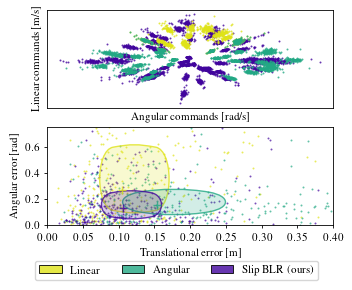

In [90]:
def angle_from_rotmat(rotmat):
    angle = np.arctan2(rotmat[1,0], rotmat[0,0])
    return angle

def ellipse_from_covariance_matrix(cov_matrix, center, color, alpha_color):
    lambdas, R = np.linalg.eig(cov_matrix[:2,:2])
    scale_x = np.sqrt(lambdas[0])
    scale_y = np.sqrt(lambdas[1])
    ellipse_angle = angle_from_rotmat(R)
    return Ellipse(center, scale_x*2, scale_y*2, angle=ellipse_angle, facecolor=alpha_color, edgecolor=color)

def ellipse_from_median_quartiles(interquartile_ranges, median, color, alpha_color):
    scale_x = interquartile_ranges[0]
    scale_y = interquartile_ranges[1]
    return Ellipse(median, scale_x, scale_y, facecolor=alpha_color, edgecolor=color)

def rectangle_from_median_quartiles(first_quartiles, third_quartiles, median, curvature, pad, edge_color, face_color):
    origin = np.array([first_quartiles[0], first_quartiles[1]])
    scale_x = third_quartiles[0] - first_quartiles[0]
    scale_y = third_quartiles[1] - first_quartiles[1]
    return FancyBboxPatch(origin, scale_x, scale_y, facecolor=face_color, edgecolor=edge_color, linewidth=1, boxstyle=BoxStyle("Round4", pad=0, rounding_size=curvature))

from matplotlib.gridspec import GridSpec
from matplotlib.patches import Ellipse, Rectangle

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
mpl.rcParams['lines.dashed_pattern'] = [2, 2]

width  = 3.402
height = width / 1.2

fig = plt.figure()
gs = GridSpec(2, 1)
axs0 = fig.add_subplot(gs[0, :])
axs1 = fig.add_subplot(gs[1, :])

fig.set_size_inches(width, height)
fig.subplots_adjust(left=.12, bottom=.21, right=.96, top=.97)

myWidth = 0.6

for axis in ['top','bottom','left','right']:
    axs0.spines[axis].set_linewidth(myWidth)
    axs1.spines[axis].set_linewidth(myWidth)

    axs0.tick_params(direction='out', length=2)
    axs1.tick_params(direction='out', length=2)

axs0.tick_params(width=myWidth)
axs1.tick_params(width=myWidth)

###################################################  colors
cmap_viridis = mpl.cm.get_cmap('viridis')
cmap_plasma = mpl.cm.get_cmap('plasma')
cmap_alpha_normal = 0.8
cmap_alpha_lighter = 0.7
cmap_alpha_much_lighter = 0.2

linear_color = cmap_viridis(0.95)                                # linear
linear_color_list = list(linear_color)
linear_color_list[3] = cmap_alpha_normal
linear_color = tuple(linear_color_list)
linear_color_list[3] = cmap_alpha_much_lighter
linear_color_lighter = tuple(linear_color_list)

angular_color = cmap_viridis(0.6)                               # angular
angular_color_list = list(angular_color)
angular_color_list[3] = cmap_alpha_normal
angular_color = tuple(angular_color_list)
angular_color_list[3] = cmap_alpha_much_lighter
angular_color_lighter = tuple(angular_color_list)

doughnut_color = cmap_plasma(0.1)                               # ours
doughnut_color_list = list(doughnut_color)
doughnut_color_list[3] = cmap_alpha_normal
doughnut_color = tuple(doughnut_color_list)
doughnut_color_list[3] = cmap_alpha_much_lighter
doughnut_color_lighter = tuple(doughnut_color_list)
###################################################

scatter_colors = [doughnut_color, linear_color, angular_color]
scatter_x = [steady_state_encoder_body_vel_yaw_doughnut, steady_state_encoder_body_vel_yaw[q1_calib_mask, :], steady_state_encoder_body_vel_yaw[q2_calib_mask, :] ]
scatter_y = [steady_state_encoder_body_vel_x_doughnut, steady_state_encoder_body_vel_x[q1_calib_mask, :], steady_state_encoder_body_vel_x[q2_calib_mask, :]]

for i in range (len(scatter_x)):
    axs0.scatter(scatter_x[i], scatter_y[i], c = scatter_colors[i], lw=0, s=2, rasterized=True)

axs1.scatter(blr_slip_prediction_errors_q1_translation, blr_slip_prediction_errors_q1_rotation, color=linear_color, s=2, lw=0, marker='o', alpha=cmap_alpha_lighter)
axs1.scatter(blr_slip_prediction_errors_q2_translation, blr_slip_prediction_errors_q2_rotation, color=angular_color, s=2, lw=0, marker='o', alpha=cmap_alpha_lighter)
axs1.scatter(blr_slip_prediction_errors_full_input_space_translation, blr_slip_prediction_errors_full_input_space_rotation, color=doughnut_color, s=2, lw=0, marker='o', alpha=cmap_alpha_lighter)

axs1.add_patch(rectangle_from_median_quartiles(q1_error_first_quartile, q1_error_third_quartile, q1_error_medians, 0.025, -0.1, edge_color=linear_color, face_color=linear_color_lighter))    # linear

axs1.add_patch(rectangle_from_median_quartiles(q2_error_first_quartile, q2_error_third_quartile, q2_error_medians, 0.03, 0, edge_color=angular_color, face_color=angular_color_lighter))    # angular

axs1.add_patch(rectangle_from_median_quartiles(doughnut_error_first_quartile, doughnut_error_third_quartile, doughnut_error_medians, 0.02, -0.01, edge_color=doughnut_color, face_color=doughnut_color_lighter))   # ours

doughnut_cross = axs1.scatter(doughnut_error_medians[0], doughnut_error_medians[1], marker='+', c=doughnut_color)
q1_cross = axs1.scatter(q1_error_medians[0], q1_error_medians[1], marker='+', c=linear_color)
q2_cross = axs1.scatter(q2_error_medians[0], q2_error_medians[1], marker='+', c=angular_color)


minimum_linear_vel_positive = 0
minimum_linear_vel_negative = 0
minimum_angular_vel_positive = 0
minimum_angular_vel_negative = 0
maximum_linear_vel_positive = 5
maximum_linear_vel_negative = -5
maximum_angular_vel_positive = 5
maximum_angular_vel_negative = -5

num_points = 100
line_width = 1
alpha = 0.1

axs0.set_xlabel(r'Angular commands [rad/s]')
axs0.set_ylabel(r'Linear commands [m/s]')
axs0.set_xticks([])
axs0.set_yticks([])

axs1.set_xlim(0, 0.4)
axs1.set_ylim(0, 0.75)
axs1.set_xlabel(r'Translational error [m]')
axs1.set_ylabel(r'Angular error [rad]')

translation_improvement = (np.median(blr_slip_prediction_errors_q1_translation) - np.median(blr_slip_prediction_errors_full_input_space_translation)) / np.median(blr_slip_prediction_errors_q1_translation) * 100
rotation_improvement = (np.median(blr_slip_prediction_errors_q2_rotation) - np.median(blr_slip_prediction_errors_full_input_space_rotation)) / np.median(blr_slip_prediction_errors_q2_rotation) * 100

print('Translation prediciton improvement : ', np.round(translation_improvement, 2),  ' %')
print('Rotation prediciton improvement : ', np.round(rotation_improvement, 2), ' %')

legend_elements = [Rectangle((0,0), width=5, height=3, facecolor=linear_color, label='Linear', linestyle='solid', edgecolor='k', linewidth=myWidth),
                   Rectangle((0,0), width=5, height=3, facecolor=angular_color, label='Angular', linestyle='solid', edgecolor='k', linewidth=myWidth),
                   Rectangle((0,0), width=5, height=3, facecolor=doughnut_color, label='Slip BLR (ours)', linestyle='solid', edgecolor='k', linewidth=myWidth)]

fig.legend(handles=legend_elements, loc='center', ncol=6, bbox_to_anchor=(0.5,0.05), prop={'size': 8})

fig.savefig('figs/sota_vs_doughnut_2_seconds_cg_v4.pdf', dpi=500)
fig.savefig('figs/sota_vs_doughnut_2_seconds_cg_v4.jpg', dpi=500)

In [ ]:
# BREAK

In [36]:
# Evaluation for 6 second horizons

window_size = 40 * 3

def compute_single_step_error(meas_state, pred_state):
    pred_error = meas_state - pred_state
    pred_error[2] = wrap2pi(pred_error[2]) # wrap yaw angle error to pi
    translation_error_squared_scalar = pred_error.T @ np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]]) @ pred_error
    rotation_error_squared_scalar = pred_error.T @ np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]) @ pred_error
    return np.sqrt(translation_error_squared_scalar), np.sqrt(rotation_error_squared_scalar)

def compute_prediction_metrics(validate_dataset, robot):
    n_test_windows = len(validate_dataset)

    cmd_left_vels_array = validate_dataset[cmd_left_str_list].to_numpy()
    cmd_right_vels_array = validate_dataset[cmd_right_str_list].to_numpy()
    transitory_left_vels_array = validate_dataset[transitory_left_str_list].to_numpy()
    transitory_right_vels_array = validate_dataset[transitory_right_str_list].to_numpy()
    idd_body_vel_x_array = validate_dataset[idd_body_vel_x_str_list].to_numpy()
    idd_body_vel_y_array = validate_dataset[idd_body_vel_y_str_list].to_numpy()
    idd_body_vel_yaw_array = validate_dataset[idd_body_vel_yaw_str_list].to_numpy()
    icp_x_array = validate_dataset[icp_x_str_list].to_numpy()
    icp_y_array = validate_dataset[icp_y_str_list].to_numpy()
    icp_yaw_array = validate_dataset[icp_yaw_str_list].to_numpy()
    icp_vel_x_array = validate_dataset[str_icp_vel_x_list].to_numpy()
    icp_vel_y_array = validate_dataset[str_icp_vel_y_list].to_numpy()
    icp_vel_yaw_array = validate_dataset[str_icp_vel_yaw_list].to_numpy()

    # TODO : Try only in steady-state or transitory-state windows to check if models perform better in some cases

    if robot=='H':
        wheel_radius = 0.33 / 2
        baseline = 0.55
        dt = 0.05
    if robot=='M':
        wheel_radius = 0.116
        baseline = 0.5927
        dt=0.05
    if robot == 'W':
        wheel_radius = 0.3
        baseline = 1.1652
        dt = 0.05

    ideal_diff_drive = Ideal_diff_drive(wheel_radius, baseline, dt)

    cmd_input_horizon = np.zeros((2, window_size))
    transitory_input_horizon = np.zeros((2, window_size))
    transitory_body_vel_horizon = np.zeros((3, window_size))

    cmd_idd_horizon_prediction = np.zeros((3, window_size))
    transitory_idd_horizon_prediction = np.zeros((3, window_size))
    blr_slip_horizon_prediction = np.zeros((3, window_size))
    icp_horizon_meas = np.zeros((3, window_size))
    icp_vel_meas = np.zeros((3, window_size))

    blr_slip_prediction_errors_human_translation = np.zeros(int(n_test_windows/3))
    blr_slip_prediction_errors_human_rotation = np.zeros(int(n_test_windows/3))
    blr_slip_prediction_errors_full_input_space_translation = np.zeros(int(n_test_windows/3))
    blr_slip_prediction_errors_full_input_space_rotation = np.zeros(int(n_test_windows/3))
    idd_body_vels_array = np.zeros((window_size, 3))
    blr_init_state_covariance = np.eye(3) * 0.1

    for j in range(2, n_test_windows-3, 3):
        # if not steady_state_mask_array[j]:
        #     continue
        cmd_input_horizon[0, :] = cmd_left_vels_array[j:j+3, :].flatten()
        cmd_input_horizon[1, :] = cmd_right_vels_array[j:j+3, :].flatten()

        transitory_input_horizon[0, :] = transitory_left_vels_array[j:j+3, :].flatten()
        transitory_input_horizon[1, :] = transitory_right_vels_array[j:j+3, :].flatten()

        transitory_body_vel_horizon[0, :] = idd_body_vel_x_array[j:j+3, :].flatten()
        transitory_body_vel_horizon[1, :] = idd_body_vel_y_array[j:j+3, :].flatten()
        transitory_body_vel_horizon[2, :] = idd_body_vel_yaw_array[j:j+3, :].flatten()

        blr_horizon_prediction_error_human_translation = 0
        blr_horizon_prediction_error_human_rotation = 0
        blr_horizon_prediction_error_full_input_space_translation = 0
        blr_horizon_prediction_error_full_input_space_rotation = 0

        idd_body_vels_array[:, 0] = idd_body_vel_x_array[j:j+3, :].flatten()
        idd_body_vels_array[:, 1] = idd_body_vel_y_array[j:j+3, :].flatten()
        idd_body_vels_array[:, 2] = idd_body_vel_yaw_array[j:j+3, :].flatten()

        icp_vel_meas[0, :] = icp_vel_x_array[j:j+3, :].flatten()
        icp_vel_meas[1, :] = icp_vel_y_array[j:j+3, :].flatten()
        icp_vel_meas[2, :] = icp_vel_yaw_array[j:j+3, :].flatten()

        prediction_means_blr_human, prediction_covariances_blr_human = full_body_slip_blr_human.predict_horizon_from_body_idd_vels(idd_body_vels_array,
                                                                                                        blr_slip_horizon_prediction[:, 0], blr_init_state_covariance)
        prediction_means_blr_full_input_space, prediction_covariances_blr_full_input_space = full_body_slip_blr_full_input_space.predict_horizon_from_body_idd_vels(idd_body_vels_array,
                                                                                                        blr_slip_horizon_prediction[:, 0], blr_init_state_covariance)

        icp_x_window = icp_x_array[j:j+3,:].flatten()
        icp_y_window = icp_y_array[j:j+3,:].flatten()
        icp_yaw_window = icp_yaw_array[j:j+3,:].flatten()

        icp_2d_state_rotated = np.zeros(3)
        last_icp_state_rotmat = np.eye(2)

        last_icp_state = np.zeros(3)

        for i in range(0, window_size):

            if i == 20 or i == 40:
                last_icp_state = icp_2d_state

            icp_2d_state_untransformed = np.array([icp_x_window[i], icp_y_window[i], icp_yaw_window[i]])
            yaw_to_rotmat2d(last_icp_state_rotmat, last_icp_state[2])
            icp_2d_state_rotated[:2] = last_icp_state_rotmat @ icp_2d_state_untransformed[:2]
            icp_2d_state_rotated[2] = icp_2d_state_untransformed[2]
            icp_2d_state = icp_2d_state_rotated + last_icp_state

            blr_horizon_prediction_error_human_translation_step, blr_horizon_prediction_error_human_rotation_step = compute_single_step_error(icp_2d_state, prediction_means_blr_human[:, i])
            blr_horizon_prediction_error_human_translation += blr_horizon_prediction_error_human_translation_step
            blr_horizon_prediction_error_human_rotation += blr_horizon_prediction_error_human_rotation_step

            blr_horizon_prediction_error_full_input_space_translation_step, blr_horizon_prediction_error_full_input_space_rotation_step = compute_single_step_error(icp_2d_state, prediction_means_blr_full_input_space[:, i])
            blr_horizon_prediction_error_full_input_space_translation += blr_horizon_prediction_error_full_input_space_translation_step
            blr_horizon_prediction_error_full_input_space_rotation += blr_horizon_prediction_error_full_input_space_rotation_step

        # blr_msre = np.diag(blr_prediction_errors @ blr_prediction_errors.T)
        # blr_slip_prediction_errors[j] = np.sqrt(np.sqrt((blr_msre.T @ blr_msre) / window_size))

        # print('blr : ', prediction_means_blr[2, -1])
        # print('icp : ', icp_horizon_meas[2, -1])

        # print(prediction_means_blr_human)
        blr_slip_prediction_errors_human_translation[int(j/3)] = blr_horizon_prediction_error_human_translation / window_size
        blr_slip_prediction_errors_human_rotation[int(j/3)] = blr_horizon_prediction_error_human_rotation / window_size
        blr_slip_prediction_errors_full_input_space_translation[int(j/3)] = blr_horizon_prediction_error_full_input_space_translation / window_size
        blr_slip_prediction_errors_full_input_space_rotation[int(j/3)] = blr_horizon_prediction_error_full_input_space_rotation / window_size

    # cmd_idd_prediction_errors = cmd_idd_prediction_errors[steady_state_mask_array]
    # transitory_idd_prediction_errors = transitory_idd_prediction_errors[steady_state_mask_array]
    # blr_slip_prediction_errors = blr_slip_prediction_errors[steady_state_mask_array]
    # gp_slip_prediction_errors = gp_slip_prediction_errors[steady_state_mask_array]
    # blr_acceleration_prediction_errors = blr_acceleration_prediction_errors[steady_state_mask_array]
    # blr_slip_acceleration_prediction_errors = blr_slip_acceleration_prediction_errors[steady_state_mask_array]

    return blr_slip_prediction_errors_human_translation, blr_slip_prediction_errors_human_rotation, blr_slip_prediction_errors_full_input_space_translation, blr_slip_prediction_errors_full_input_space_rotation

blr_slip_prediction_errors_human_translation, blr_slip_prediction_errors_human_rotation, blr_slip_prediction_errors_full_input_space_translation, blr_slip_prediction_errors_full_input_space_rotation = compute_prediction_metrics(validate_dataset, 'H')

/tmp/ipykernel_38930/1219318993.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Translation prediciton improvement :  12.097234562467703  %
Rotation prediciton improvement :  11.167897610660823  %


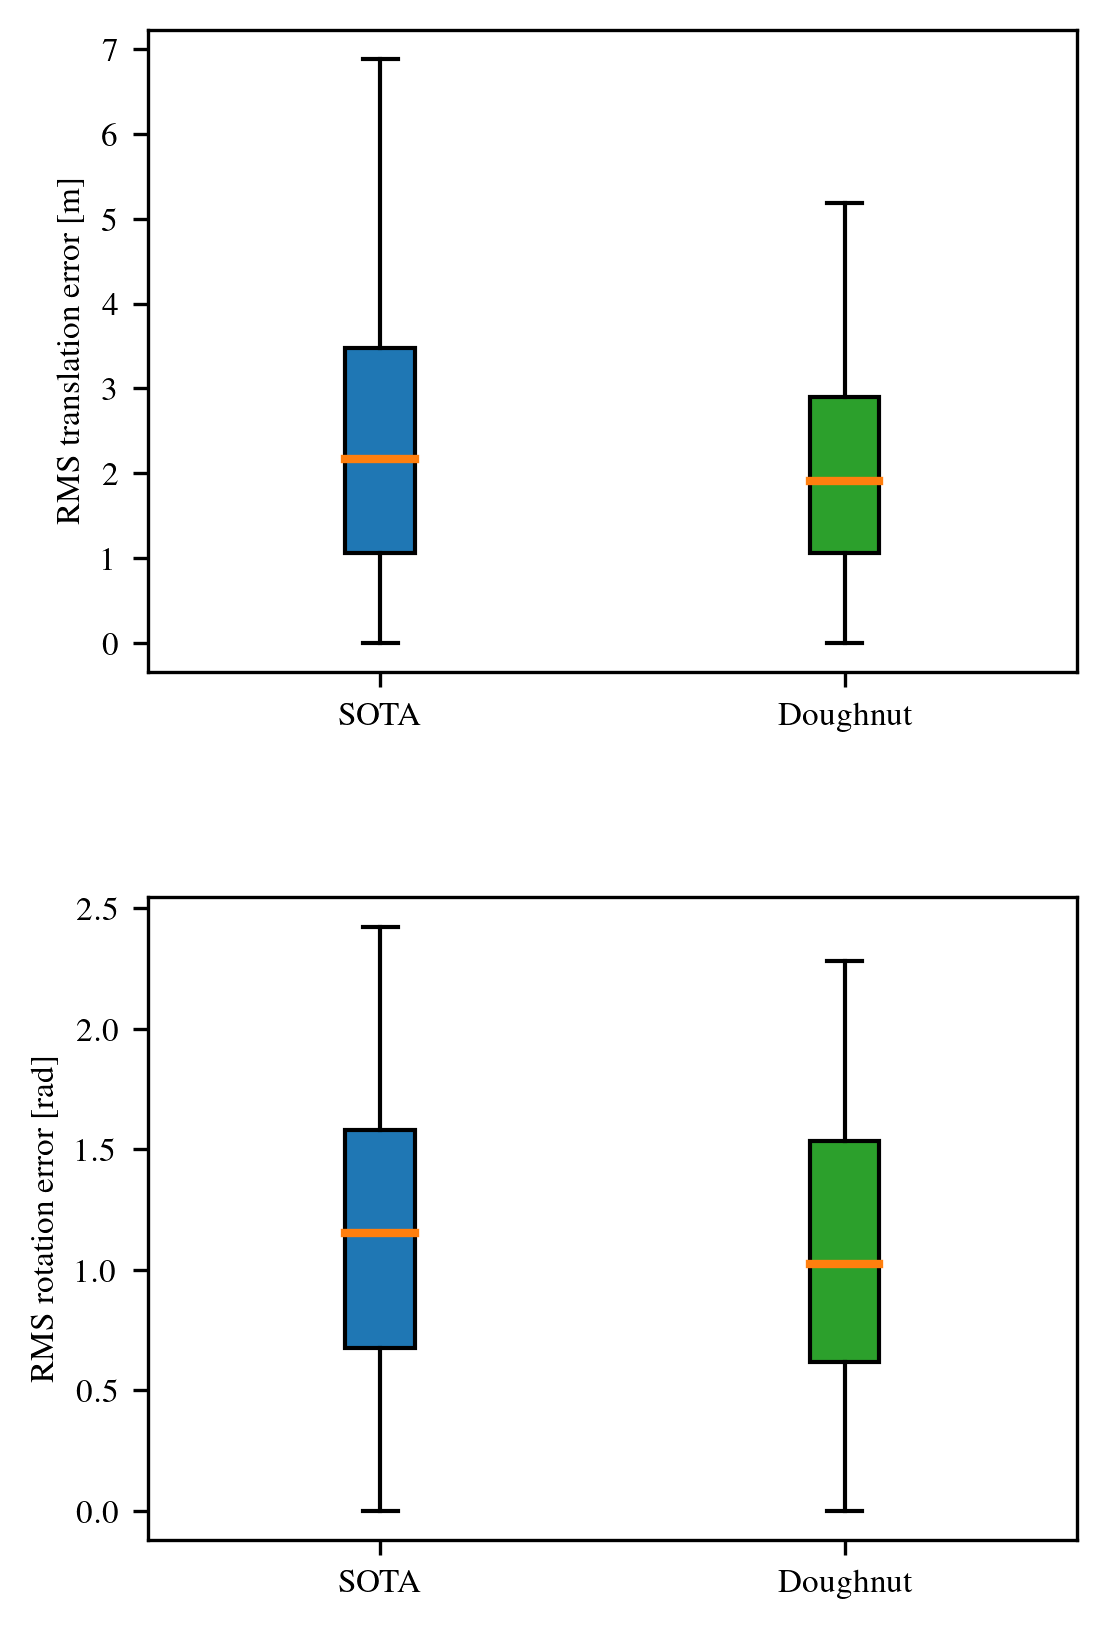

In [211]:
width  = 3.402
height = width / 0.5

fig, axs = plt.subplots(2, 1, dpi=300, gridspec_kw={'hspace': 0.35, 'wspace': 0.23})
fig.set_size_inches(width, height)
fig.subplots_adjust(left=.08, bottom=0.18, right=.99, top=.92)
fig.tight_layout()

medians_color = 'C1'
sota_color = 'C0'
doughnut_color = 'C2'

axs[0].boxplot(blr_slip_prediction_errors_human_translation, positions=[0], showfliers=False, labels=['SOTA'], patch_artist=True,
                   boxprops=dict(facecolor = sota_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))
axs[0].boxplot(blr_slip_prediction_errors_full_input_space_translation, positions=[1], showfliers=False, labels=['Doughnut'], patch_artist=True,
                   boxprops=dict(facecolor = doughnut_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))

axs[1].boxplot(blr_slip_prediction_errors_human_rotation, positions=[0], showfliers=False, labels=['SOTA'], patch_artist=True,
                   boxprops=dict(facecolor = sota_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))
axs[1].boxplot(blr_slip_prediction_errors_full_input_space_rotation, positions=[1], showfliers=False, labels=['Doughnut'], patch_artist=True,
                   boxprops=dict(facecolor = doughnut_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))

axs[0].set_ylabel('RMS translation error [m]')
axs[1].set_ylabel('RMS rotation error [rad]')


translation_improvement = (np.median(blr_slip_prediction_errors_human_translation) - np.median(blr_slip_prediction_errors_full_input_space_translation)) / np.median(blr_slip_prediction_errors_human_translation) * 100
rotation_improvement = (np.median(blr_slip_prediction_errors_human_rotation) - np.median(blr_slip_prediction_errors_full_input_space_rotation)) / np.median(blr_slip_prediction_errors_human_rotation) * 100

print('Translation prediciton improvement : ', translation_improvement,  ' %')
print('Rotation prediciton improvement : ', rotation_improvement, ' %')